# GraphAttentionNets

In [1]:
import sys
sys.path.insert(0,'..')
sys.path.insert(0,'../data generation')
sys.path.insert(0,'../model architecture')

In [2]:
from data_generator import load_dataset
from models import *
from experiment_tools import *
from params import *

Using backend: pytorch


## Dataset
### Set hyper-parameters: dataset

In [3]:
test_cases, dataset_size, std_scaler, test_type = get_test_params()

### Select a dataset

In [4]:
idx = 0
test_case = test_cases[idx]
test_case

'pglib_opf_case24_ieee_rts.m'

### Load a dataset

In [5]:
dataset = load_dataset(test_case=test_case,
                       dataset_size=dataset_size,
                       std_scaler=std_scaler,
                       test_type=test_type,
                       gen_only=True)

### Check the shape of the dataset
- number of samples
- number of buses
- number of generators

In [6]:
# (num_samples, num_buses),(num_samples, num_gens) 
dataset['x'].shape, dataset['y'].shape 

((30000, 24, 1), (30000, 24, 6))

### Check the shape of the graph

In [7]:
g = get_graph_structure(dataset['g'])

In [8]:
dataset['g'].keys()

dict_keys(['bus_idx', 'fbus2tbus', 'gen_bus_idx'])

In [9]:
dataset['g']['bus_idx'].shape, dataset['g']['fbus2tbus'].shape, dataset['g']['gen_bus_idx'].shape

((24,), (38, 2), (33, 1))

In [10]:
g

Graph(num_nodes=24, num_edges=100,
      ndata_schemes={}
      edata_schemes={})

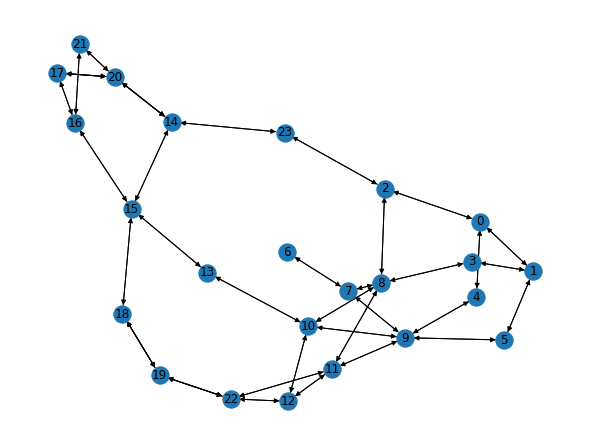

In [11]:
nx.draw(g.to_networkx(), with_labels=True)
plt.show()

## Model
### Set hyper-parameters: model

In [12]:
model_name = "gat"
num_epochs, batch_size, lr, threshold, print_step = get_h_params(model_name)

### Set data-loaders

In [13]:
train_loader, val_loader, test_loader = data_prep(dataset=dataset,
                                                  batch_size=batch_size)

/Users/jeehyunpark/git_local/UT/Project_EE394V_SPR2021/code/experiments/experiment_tools.py:42: RuntimeWarning: invalid value encountered in true_divide
  x_normed = np.nan_to_num(dataset["x"] / dataset["x"].max(axis=0), nan=0.0)


### Check the shape of the data-loaders
- number of batch
- number of buses
- number of generators

In [14]:
feature, label = next(iter(train_loader))
feature.shape, label.shape

(torch.Size([24, 1]), torch.Size([24, 6]))

In [15]:
feature, label = next(iter(val_loader))
feature.shape, label.shape

(torch.Size([24, 1]), torch.Size([24, 6]))

In [16]:
feature, label = next(iter(test_loader))
feature.shape, label.shape

(torch.Size([24, 1]), torch.Size([24, 6]))

### Set a model

In [17]:
# gat = GraphAttentionNet(in_feats=feature.shape[1],
#                         out_feats=label.shape[1],
#                         num_heads=1)

gat = GAT(g=g,
          num_layers=3,
          in_dim=feature.shape[1],
          num_hidden=64,
          num_classes=label.shape[1],
          heads=[3, 3, 3],
          activation=F.relu,
          feat_drop=0,
          attn_drop=0,
          negative_slope=0.2,
          residual=False)

# loss func
# loss_func = nn.BCEWithLogitsLoss()
loss_func = nn.MSELoss()
# loss_func = nn.NLLLoss()

# optim
optimizer = optim.Adam(gat.parameters(), lr=lr)

gat.eval()

GAT(
  (gat_layers): ModuleList(
    (0): GATConv(
      (fc): Linear(in_features=1, out_features=192, bias=False)
      (feat_drop): Dropout(p=0, inplace=False)
      (attn_drop): Dropout(p=0, inplace=False)
      (leaky_relu): LeakyReLU(negative_slope=0.2)
    )
    (1): GATConv(
      (fc): Linear(in_features=192, out_features=192, bias=False)
      (feat_drop): Dropout(p=0, inplace=False)
      (attn_drop): Dropout(p=0, inplace=False)
      (leaky_relu): LeakyReLU(negative_slope=0.2)
    )
    (2): GATConv(
      (fc): Linear(in_features=192, out_features=192, bias=False)
      (feat_drop): Dropout(p=0, inplace=False)
      (attn_drop): Dropout(p=0, inplace=False)
      (leaky_relu): LeakyReLU(negative_slope=0.2)
    )
    (3): GATConv(
      (fc): Linear(in_features=192, out_features=18, bias=False)
      (feat_drop): Dropout(p=0, inplace=False)
      (attn_drop): Dropout(p=0, inplace=False)
      (leaky_relu): LeakyReLU(negative_slope=0.2)
    )
  )
  (tanh): Tanh()
)

### Train the model

In [18]:
train_history, val_history  = train(net=gat,
      train_loader=train_loader,
      val_loader=val_loader,
      optimizer=optimizer,
      loss_func=loss_func,
      model_name=model_name,
      dataset_name=test_case,
      num_epochs=num_epochs,
      print_step=print_step)

> case: pglib_opf_case24_ieee_rts
> model: gat
- num of params: 78564
- training
	[epoch: 1, iter:  1000]	loss: 0.18319	val loss: 0.18166
	[epoch: 1, iter:  2000]	loss: 0.16066	val loss: 0.13437
	[epoch: 1, iter:  3000]	loss: 0.12797	val loss: 0.12285
	[epoch: 1, iter:  4000]	loss: 0.11590	val loss: 0.11219
	[epoch: 1, iter:  5000]	loss: 0.09561	val loss: 0.08743
	[epoch: 1, iter:  6000]	loss: 0.08409	val loss: 0.07712
	[epoch: 1, iter:  7000]	loss: 0.07811	val loss: 0.07615
	[epoch: 1, iter:  8000]	loss: 0.07239	val loss: 0.06956
	[epoch: 1, iter:  9000]	loss: 0.07074	val loss: 0.07188
	[epoch: 1, iter: 10000]	loss: 0.06844	val loss: 0.06545
	[epoch: 1, iter: 11000]	loss: 0.06700	val loss: 0.06431
	[epoch: 1, iter: 12000]	loss: 0.06509	val loss: 0.06371
	[epoch: 1, iter: 13000]	loss: 0.06393	val loss: 0.06385
	[epoch: 1, iter: 14000]	loss: 0.06201	val loss: 0.06047
	[epoch: 1, iter: 15000]	loss: 0.06047	val loss: 0.05902
	[epoch: 1, iter: 16000]	loss: 0.05988	val loss: 0.05858
	[epoch

	[epoch: 7, iter: 11000]	loss: 0.03588	val loss: 0.03331
	[epoch: 7, iter: 12000]	loss: 0.03486	val loss: 0.03236
	[epoch: 7, iter: 13000]	loss: 0.03226	val loss: 0.03243
	[epoch: 7, iter: 14000]	loss: 0.03428	val loss: 0.04686
	[epoch: 7, iter: 15000]	loss: 0.03658	val loss: 0.03890
	[epoch: 7, iter: 16000]	loss: 0.03417	val loss: 0.03269
	[epoch: 7, iter: 17000]	loss: 0.03544	val loss: 0.03248
	[epoch: 7, iter: 18000]	loss: 0.03225	val loss: 0.03222
	[epoch: 7, iter: 19000]	loss: 0.03346	val loss: 0.03326
	[epoch: 7, iter: 20000]	loss: 0.03298	val loss: 0.03500
	[epoch: 7, iter: 21000]	loss: 0.03385	val loss: 0.03164
	- validation loss decreased (0.03416->0.03164): the best model was updated.
	[epoch: 8, iter:  1000]	loss: 0.04172	val loss: 0.03469
	[epoch: 8, iter:  2000]	loss: 0.03638	val loss: 0.03261
	[epoch: 8, iter:  3000]	loss: 0.03157	val loss: 0.03172
	[epoch: 8, iter:  4000]	loss: 0.03222	val loss: 0.03419
	[epoch: 8, iter:  5000]	loss: 0.03357	val loss: 0.03223
	[epoch: 8,

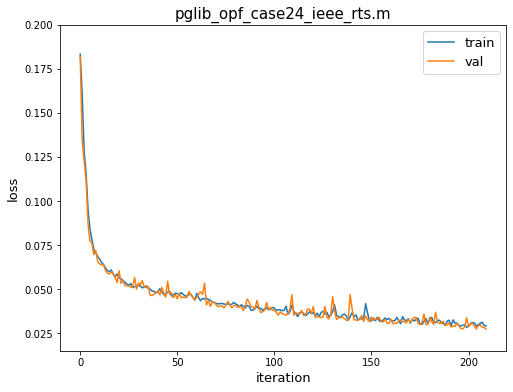

In [25]:
plt.plot(train_history, label="train")
plt.plot(val_history, label="val")
plt.title(test_case, fontsize=15)
plt.xlabel("iteration", fontsize=13)
plt.ylabel("loss", fontsize=13)
plt.ylim(0.015, 0.2)
plt.legend(fontsize=13)
plt.show()

### Test the model

In [20]:
test(net=gat,
     test_loader=test_loader,
     model_name="gat",
     dataset_name=test_case,
     threshold=0.001)

- testing
	accuracy: 18.4929%


## Attention weights visualization

In [21]:
fig, ax = plt.subplots()
plot(g=g, attention=, ax=ax)

SyntaxError: invalid syntax (<ipython-input-21-bcd9426cae6c>, line 2)

In [ ]:
g

In [ ]:
weights = {}
for name, param in gat.named_parameters():
    weights[name] = param

In [ ]:
weights

In [ ]:
weights['gat_layers.3.attn_l'].shape

In [ ]:
weights['gat_layers.3.attn_r']